# Import Data Set and Deal with Data Set

**Step 1: First import the datase**

In [1]:
import pandas as pd

file_path = "melb_housing_filtered3.csv"

data = pd.read_csv(file_path)

This data set has removed outliers. Here we modify the representation format of ADDRESS, and then remove DATE, YEARBUILT, LATTITUDE and LONGTITUDE:

**Step 2: Delete some irrelevant or no longer necessary columns**

In [2]:
data['ADDRESS'] = data['ADDRESS'].str.split().str[-2:].str.join(' ')
# 删除"DATE"和"YEARBUILT"列
data.drop(columns=['DATE', 'YEARBUILT', 'LATTITUDE', 'LONGTITUDE'], inplace=True)

Since price_by_area is obtained through LANDSIZE, BUILDGAR and PRICE, these three columns are also removed here:

In [3]:
data.drop(columns=['LANDSIZE', 'PRICE', 'BUILDINGAR', 'LANDSIZE'], inplace=True)

In [4]:
data.drop(columns=['PROPERTYCO'], inplace = True)

**Step 4: Divide into multiple sub-datasets according to type**

In [5]:
type_counts = data['TYPE'].value_counts()
print(type_counts)

h    4046
u    1414
t     571
Name: TYPE, dtype: int64


In [6]:
# Use groupby to group data according to the "TYPE" column
grouped = data.groupby('TYPE')

#Create a dictionary to store different types of sub-datasets
sub_datasets = {}

# Loop through each group and store it in a dictionary
for group_name, group_data in grouped:
     sub_datasets[group_name] = group_data

# Now you can access different types of subdatasets, for example:
house_data = sub_datasets['h'] # Get sub-datasets of type "house"
unit_data = sub_datasets['u'] # Get the sub-dataset of type "unit"
townhouse_data = sub_datasets['t'] # Get sub-datasets of type "townhouse"

Drop 'Type' from each dataset:

In [7]:
# Remove the "TYPE" column from the "house" type subdataset
house_data = sub_datasets['h'].drop(columns=['TYPE'])

# Remove the "TYPE" column from the "unit" type subdataset
unit_data = sub_datasets['u'].drop(columns=['TYPE'])

# Remove the "TYPE" column from the "townhouse" type subdataset
townhouse_data = sub_datasets['t'].drop(columns=['TYPE'])

# Features Selection

**Step 3: Perform correlation analysis on category variables in each sub-dataset.**

In [8]:
# List of column names
category_columns = ['SUBURB', 'ADDRESS', 'METHOD', 'SELLERG', 'COUNCILARE', 'REGIONNAME', 'POSTCODE', "AREANUM"]

# Change columns to category type in each subdataset
for dataset in [house_data, unit_data, townhouse_data]:
     dataset[category_columns] = dataset[category_columns].astype('category')

In [9]:
# Extract "category" data from "house_data"
house_data_category = house_data.select_dtypes(include='category')

# Extract "category" data from "unit_data"
unit_data_category = unit_data.select_dtypes(include='category')

# Extract "category" data from "townhouse_data"
townhouse_data_category = townhouse_data.select_dtypes(include='category')

house_data_category

In [10]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# Create an empty correlation matrix
correlation_matrix = pd.DataFrame(index=house_data_category.columns, columns=house_data_category.columns)

# Loop to calculate Cramér's V and populate the correlation matrix
for col1 in house_data_category.columns:
     for col2 in house_data_category.columns:
         if col1 == col2:
             correlation_matrix.loc[col1, col2] = 1.0
         else:
             #Create contingency table
             contingency_table = pd.crosstab(house_data_category[col1], house_data_category[col2])
             chi2, _, _, _ = chi2_contingency(contingency_table)
             n = contingency_table.sum().sum()
             phi2 = chi2/n
             r, k = contingency_table.shape
             phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
             rcorr = r - ((r-1)**2)/(n-1)
             kcorr = k - ((k-1)**2)/(n-1)
             correlation_matrix.loc[col1, col2] = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Display correlation matrix
print(correlation_matrix)

              SUBURB   ADDRESS    METHOD   SELLERG  POSTCODE COUNCILARE  \
SUBURB           1.0  0.497127  0.154173  0.338493  0.987244   0.953814   
ADDRESS     0.497127       1.0       0.0  0.285704  0.490121   0.492935   
METHOD      0.154173       0.0       1.0  0.116533  0.150429   0.142439   
SELLERG     0.338493  0.285704  0.116533       1.0  0.310035   0.446842   
POSTCODE    0.987244  0.490121  0.150429  0.310035       1.0   0.947228   
COUNCILARE  0.953814  0.492935  0.142439  0.446842  0.947228        1.0   
REGIONNAME  0.965989  0.528214   0.11071  0.527918   0.93845    0.80243   
AREANUM     0.965893  0.455298  0.092873  0.496796  0.952599   0.743758   

           REGIONNAME   AREANUM  
SUBURB       0.965989  0.965893  
ADDRESS      0.528214  0.455298  
METHOD        0.11071  0.092873  
SELLERG      0.527918  0.496796  
POSTCODE      0.93845  0.952599  
COUNCILARE    0.80243  0.743758  
REGIONNAME        1.0  0.495689  
AREANUM      0.495689       1.0  


The results show that there is a significant correlation between "SUBURB", "COUNCILARE", "POSTCODE", "REGIONNAME" and "AREANUM".

In [11]:
# Count the number of distinct values in the "SUBURB" column
suburb_count = house_data_category['SUBURB'].nunique()

# Count the number of distinct values in the "REGIONNAME" column
regionname_count = house_data_category['REGIONNAME'].nunique()

# Count the number of distinct values in the "COUNCILARE" column
councilare_count = house_data_category['COUNCILARE'].nunique()

# POSTCODE
postcode_count = house_data_category['POSTCODE'].nunique()

# AREANUM
areanum_count =  house_data_category['AREANUM'].nunique()

print("Number of different values:")
print("SUBURB:", suburb_count)
print("REGIONNAME:", regionname_count)
print("COUNCILARE:", councilare_count)
print('POSTCODE', postcode_count)
print('AREANUM', areanum_count)

Number of different values:
SUBURB: 278
REGIONNAME: 8
COUNCILARE: 31
POSTCODE 180
AREANUM 9


Since the number of regionnames is minimal, retaining regionnames can simplify the model as much as possible.

In [12]:
# Remove "SUBURB" and "COUNCILARE" columns from "house_data"
house_data = house_data.drop(columns=['SUBURB', 'COUNCILARE', "POSTCODE", "AREANUM"])

uni_data_category

In [13]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# Create an empty correlation matrix
correlation_matrix = pd.DataFrame(index=unit_data_category.columns, columns=unit_data_category.columns)

# Loop to calculate Cramér's V and populate the correlation matrix
for col1 in unit_data_category.columns:
     for col2 in unit_data_category.columns:
         if col1 == col2:
             correlation_matrix.loc[col1, col2] = 1.0
         else:
             #Create contingency table
             contingency_table = pd.crosstab(unit_data_category[col1], unit_data_category[col2])
             chi2, _, _, _ = chi2_contingency(contingency_table)
             n = contingency_table.sum().sum()
             phi2 = chi2/n
             r, k = contingency_table.shape
             phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
             rcorr = r - ((r-1)**2)/(n-1)
             kcorr = k - ((k-1)**2)/(n-1)
             correlation_matrix.loc[col1, col2] = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Display correlation matrix
print(correlation_matrix)

              SUBURB   ADDRESS    METHOD   SELLERG  POSTCODE COUNCILARE  \
SUBURB           1.0  0.575663       0.0  0.333368  0.983192   0.933239   
ADDRESS     0.575663       1.0       0.0   0.20278  0.571421   0.571494   
METHOD           0.0       0.0       1.0  0.272646       0.0   0.104342   
SELLERG     0.333368   0.20278  0.272646       1.0  0.312916   0.453384   
POSTCODE    0.983192  0.571421       0.0  0.312916       1.0   0.936739   
COUNCILARE  0.933239  0.571494  0.104342  0.453384  0.936739        1.0   
REGIONNAME  0.941092  0.477135  0.061019  0.490735  0.947839   0.836458   
AREANUM     0.942096  0.581031  0.070077  0.474101  0.923936   0.705238   

           REGIONNAME   AREANUM  
SUBURB       0.941092  0.942096  
ADDRESS      0.477135  0.581031  
METHOD       0.061019  0.070077  
SELLERG      0.490735  0.474101  
POSTCODE     0.947839  0.923936  
COUNCILARE   0.836458  0.705238  
REGIONNAME        1.0  0.501009  
AREANUM      0.501009       1.0  


In [14]:
# Count the number of distinct values in the "SUBURB" column
suburb_count = unit_data_category['SUBURB'].nunique()

# Count the number of distinct values in the "REGIONNAME" column
regionname_count = unit_data_category['REGIONNAME'].nunique()

# Count the number of distinct values in the "COUNCILARE" column
councilare_count = unit_data_category['COUNCILARE'].nunique()

# POSTCODE
postcode_count = unit_data_category['POSTCODE'].nunique()

# AREANUM
areanum_count =  unit_data_category['AREANUM'].nunique()

print("Number of different values:")
print("SUBURB:", suburb_count)
print("REGIONNAME:", regionname_count)
print("COUNCILARE:", councilare_count)
print('POSTCODE', postcode_count)
print('AREANUM', areanum_count)

Number of different values:
SUBURB: 167
REGIONNAME: 6
COUNCILARE: 25
POSTCODE 124
AREANUM 9


Based on approximate results and for the same reason, 'SUBURB', 'COUNCILARE', "POSTCODE" and "AREANUM" will be removed here.

In [15]:
unit_data = unit_data.drop(columns=['SUBURB', 'COUNCILARE', "POSTCODE", "AREANUM"])

townhouse_data

In [16]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# Create an empty correlation matrix
correlation_matrix = pd.DataFrame(index=townhouse_data_category.columns, columns=townhouse_data_category.columns)

# Loop to calculate Cramér's V and populate the correlation matrix
for col1 in townhouse_data_category.columns:
     for col2 in townhouse_data_category.columns:
         if col1 == col2:
             correlation_matrix.loc[col1, col2] = 1.0
         else:
             #Create contingency table
             contingency_table = pd.crosstab(townhouse_data_category[col1], townhouse_data_category[col2])
             chi2, _, _, _ = chi2_contingency(contingency_table)
             n = contingency_table.sum().sum()
             phi2 = chi2/n
             r, k = contingency_table.shape
             phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
             rcorr = r - ((r-1)**2)/(n-1)
             kcorr = k - ((k-1)**2)/(n-1)
             correlation_matrix.loc[col1, col2] = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Display correlation matrix
print(correlation_matrix)

              SUBURB   ADDRESS    METHOD   SELLERG  POSTCODE COUNCILARE  \
SUBURB           1.0  0.407445  0.061491  0.322014  0.963942   0.870939   
ADDRESS     0.407445       1.0  0.199242       0.0  0.359566   0.303751   
METHOD      0.061491  0.199242       1.0  0.172361  0.125534   0.114664   
SELLERG     0.322014       0.0  0.172361       1.0  0.348698   0.464822   
POSTCODE    0.963942  0.359566  0.125534  0.348698       1.0   0.889515   
COUNCILARE  0.870939  0.303751  0.114664  0.464822  0.889515        1.0   
REGIONNAME  0.874653   0.36218  0.072982  0.542211  0.903454   0.905855   
AREANUM      0.87698  0.333915   0.10387  0.486385  0.854178   0.716266   

           REGIONNAME   AREANUM  
SUBURB       0.874653   0.87698  
ADDRESS       0.36218  0.333915  
METHOD       0.072982   0.10387  
SELLERG      0.542211  0.486385  
POSTCODE     0.903454  0.854178  
COUNCILARE   0.905855  0.716266  
REGIONNAME        1.0  0.677166  
AREANUM      0.677166       1.0  


In [17]:
# Count the number of distinct values in the "SUBURB" column
suburb_count = townhouse_data_category['SUBURB'].nunique()

# Count the number of distinct values in the "REGIONNAME" column
regionname_count = townhouse_data_category['REGIONNAME'].nunique()

# Count the number of distinct values in the "COUNCILARE" column
councilare_count = townhouse_data_category['COUNCILARE'].nunique()

# POSTCODE
postcode_count = townhouse_data_category['POSTCODE'].nunique()

# AREANUM
areanum_count =  townhouse_data_category['AREANUM'].nunique()

print("Number of different values:")
print("SUBURB:", suburb_count)
print("REGIONNAME:", regionname_count)
print("COUNCILARE:", councilare_count)
print('POSTCODE', postcode_count)
print('AREANUM', areanum_count)

Number of different values:
SUBURB: 138
REGIONNAME: 5
COUNCILARE: 23
POSTCODE 105
AREANUM 8


Based on approximate results and for the same reason, 'SUBURB', 'COUNCILARE', "POSTCODE" amd "AREANUM" will be removed here.

In [18]:
townhouse_data_category = townhouse_data_category.drop(columns=['SUBURB', 'COUNCILARE', "POSTCODE", "AREANUM"])

**step 4: Perform correlation analysis on category variables in each sub-dataset.**

In [19]:
# Extract integer and floating point data from "house_data"
house_data_num = house_data.select_dtypes(include=['int64', 'float64'])

# Extract integer and floating point data from "unit_data"
unit_data_num = unit_data.select_dtypes(include=['int64', 'float64'])

# Extract integer and floating point data from "townhouse_data"
townhouse_data_num = townhouse_data.select_dtypes(include=['int64', 'float64'])

# Exclude "price_by_area" column from "house_data"
house_data_num = house_data_num.drop(columns=['price_by_area'])

# Exclude "price_by_area" column from "unit_data"
unit_data_num = unit_data_num.drop(columns=['price_by_area'])

# Exclude "price_by_area" column from "townhouse_data"
townhouse_data_num = townhouse_data_num.drop(columns=['price_by_area'])

house_data

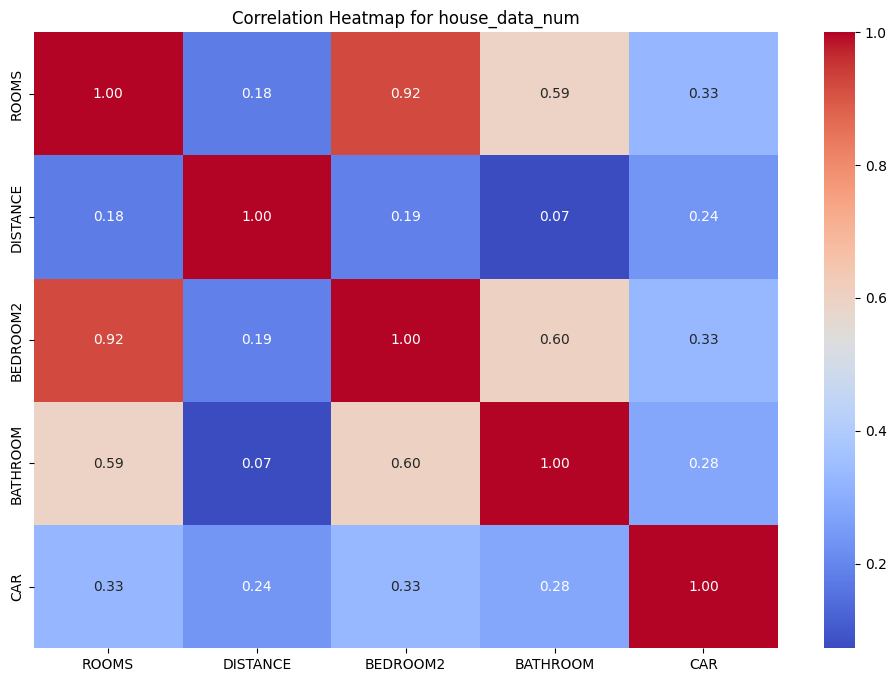

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = house_data_num.corr()

# Visualize the correlation matrix using heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for house_data_num")
plt.show()

From the visual results, there is a high or moderate positive correlation between ROOMS and BEDROOM2 and BATHROOM. Here we choose to remove BEDROOM2 and BATHROOM.

In [21]:
# Remove the "BEDROOM2" and "BATHROOM" columns from "house_data"
house_data = house_data.drop(columns=['BEDROOM2', 'BATHROOM'])

unit_data

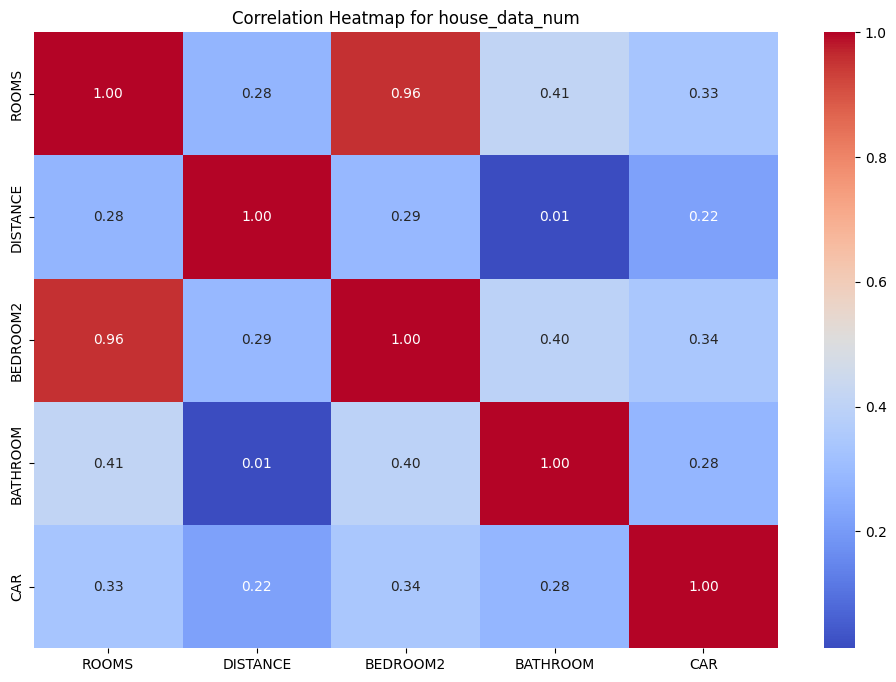

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = unit_data_num.corr()

# Visualize the correlation matrix using heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for house_data_num")
plt.show()

It can be found that for Unit type data, there is no obvious positive correlation between ROOM2 and BATHROOM.

So only "BEDROOM2" is removed here.

In [23]:
# Remove the "BEDROOM2" and "BATHROOM" columns from "house_data"
unit_data = unit_data.drop(columns=['BEDROOM2'])

townhouse_data

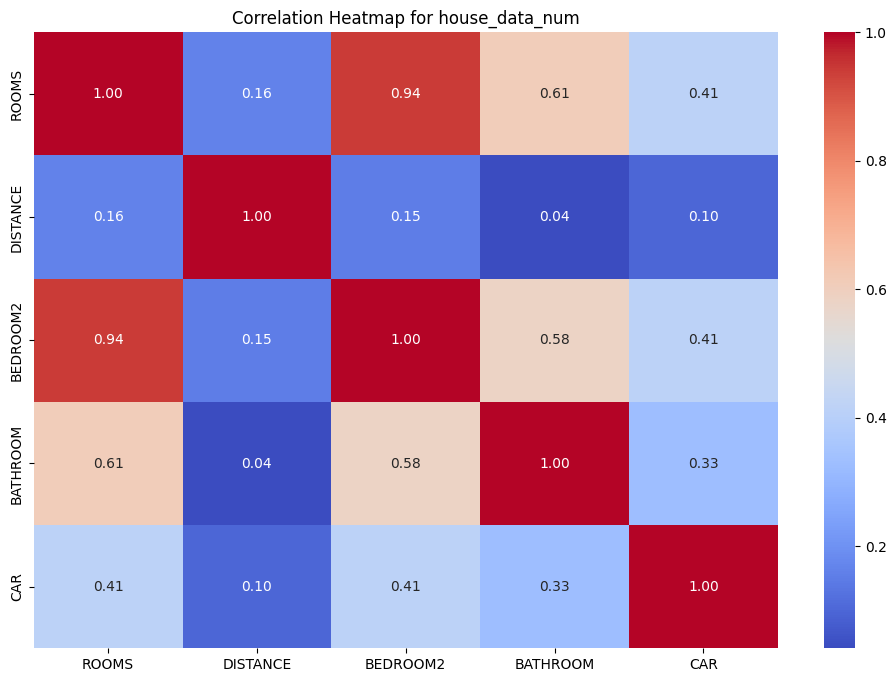

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = townhouse_data_num.corr()

# Visualize the correlation matrix using heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for house_data_num")
plt.show()

The correlations shown by the numerical variables of TOWNHOUSE and HOUSE are basically close.

In [25]:
# Remove the "BEDROOM2" and "BATHROOM" columns from "house_data"
townhouse_data = townhouse_data.drop(columns=['BEDROOM2', 'BATHROOM'])

# Models Building

## Generate new variables as target variable

house_data

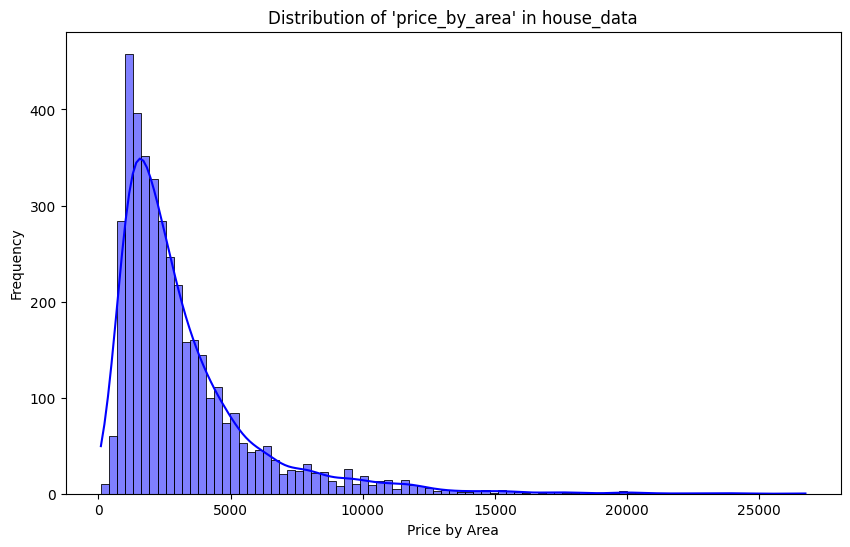

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(house_data['price_by_area'], kde=True, color='b')
plt.title("Distribution of 'price_by_area' in house_data")
plt.xlabel("Price by Area")
plt.ylabel("Frequency")
plt.show()

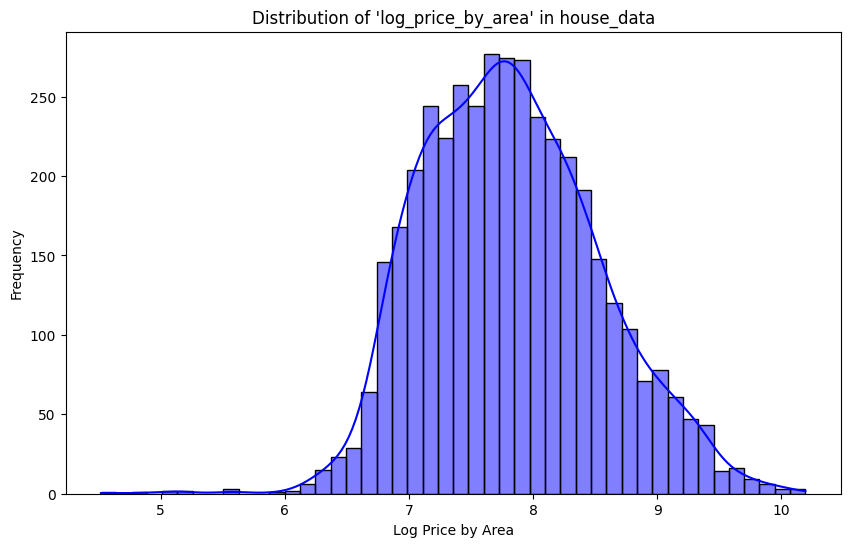

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

house_data['log_price_by_area'] = np.log(house_data['price_by_area'])

plt.figure(figsize=(10, 6))
sns.histplot(house_data['log_price_by_area'], kde=True, color='b')
plt.title("Distribution of 'log_price_by_area' in house_data")
plt.xlabel("Log Price by Area")
plt.ylabel("Frequency")
plt.show()

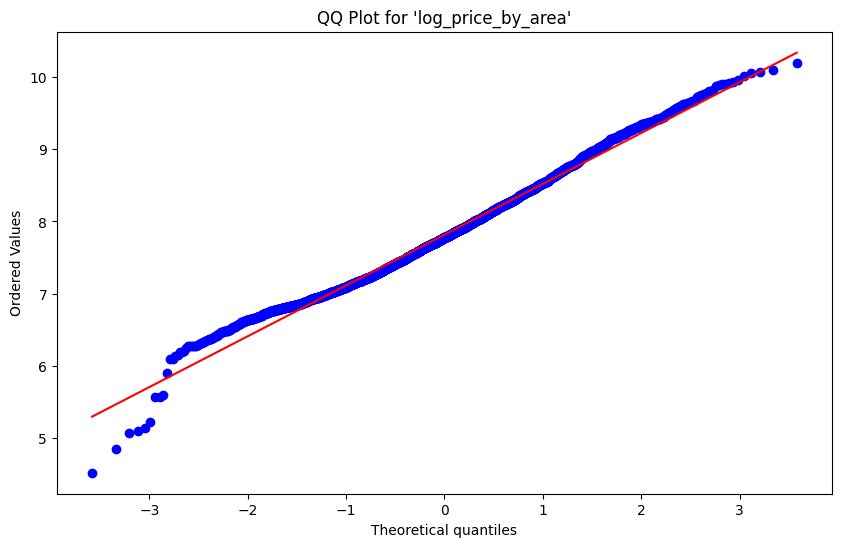

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(house_data['log_price_by_area'], dist="norm", plot=plt)
plt.title("QQ Plot for 'log_price_by_area'")
plt.show()

In [29]:
import numpy as np

mean_log_price = np.mean(house_data['log_price_by_area'])
std_log_price = np.std(house_data['log_price_by_area'])

lower_limit = mean_log_price - 3 * std_log_price
upper_limit = mean_log_price + 3 * std_log_price

filtered_house_data = house_data[(house_data['log_price_by_area'] >= lower_limit) & (house_data['log_price_by_area'] <= upper_limit)]

num_outliers_removed = len(house_data) - len(filtered_house_data)
print(f"Number of outliers removed: {num_outliers_removed}")

Number of outliers removed: 15


C:\Users\yejiu\AppData\Local\Temp\ipykernel_3300\2208989586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_house_data['log_price_by_area'] = np.log(filtered_house_data['price_by_area'])


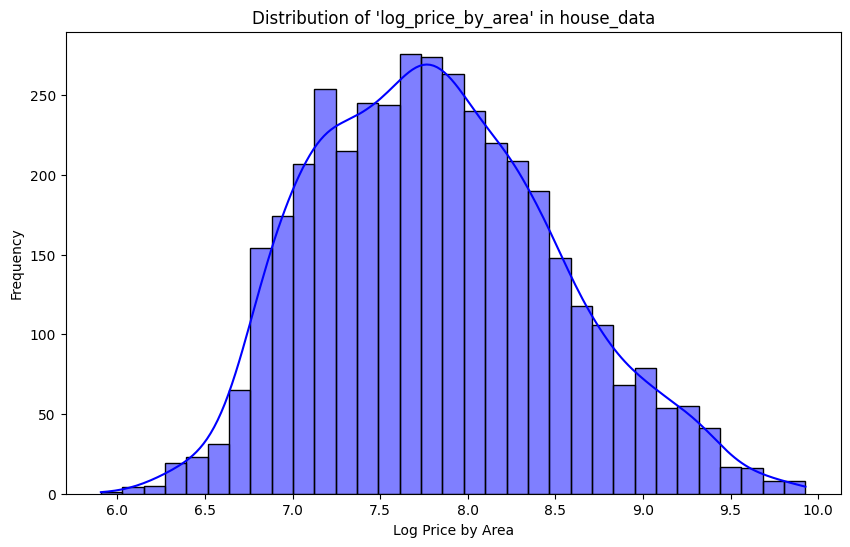

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

filtered_house_data['log_price_by_area'] = np.log(filtered_house_data['price_by_area'])

plt.figure(figsize=(10, 6))
sns.histplot(filtered_house_data['log_price_by_area'], kde=True, color='b')
plt.title("Distribution of 'log_price_by_area' in house_data")
plt.xlabel("Log Price by Area")
plt.ylabel("Frequency")
plt.show()

In [31]:
import pandas as pd

filtered_house_data.drop('price_by_area', axis=1, inplace=True)

filtered_house_data['log_price_by_area_interval'] = pd.cut(
    filtered_house_data['log_price_by_area'],
    bins=[6, 7, 8, 9, 10],
    labels=['6-7', '7-8', '8-9', '9-10']
)

valid_intervals = ['6-7', '7-8', '8-9', '9-10']
filtered_house_data = filtered_house_data[filtered_house_data['log_price_by_area_interval'].isin(valid_intervals)]

filtered_house_data.drop('log_price_by_area', axis=1, inplace=True)

C:\Users\yejiu\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\yejiu\AppData\Local\Temp\ipykernel_3300\427615544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_house_data['log_price_by_area_interval'] = pd.cut(


In [32]:
filtered_house_data

,ADDRESS,ROOMS,METHOD,SELLERG,DISTANCE,CAR,REGIONNAME,log_price_by_area_interval
0,Bloomburg St,2,S,Biggin,2.5,0,Northern Metropolitan,8-9
1,Charles St,3,SP,Biggin,2.5,0,Northern Metropolitan,9-10
2,Park St,4,VB,Nelson,2.5,2,Northern Metropolitan,9-10
3,Yarra St,3,S,Nelson,2.5,0,Northern Metropolitan,8-9
4,Charles St,2,S,Nelson,2.5,2,Northern Metropolitan,8-9
...,...,...,...,...,...,...,...,...
6024,Bamford Av,4,S,YPA,16.5,2,Northern Metropolitan,7-8
6025,Pershore Ct,3,S,Barry,16.5,1,Northern Metropolitan,6-7
6026,Sherwin St,3,S,Ray,35.5,1,Northern Victoria,6-7
6027,Cecil St,3,VB,Williams,6.8,0,Western Metropolitan,8-9


In [33]:
# Calculate the frequency of different types in the "price_by_area_interval" column
frequency = filtered_house_data['log_price_by_area_interval'].value_counts()

#Print frequency results
print(frequency)

7-8     2025
8-9     1294
6-7      471
9-10     240
Name: log_price_by_area_interval, dtype: int64


unit_data

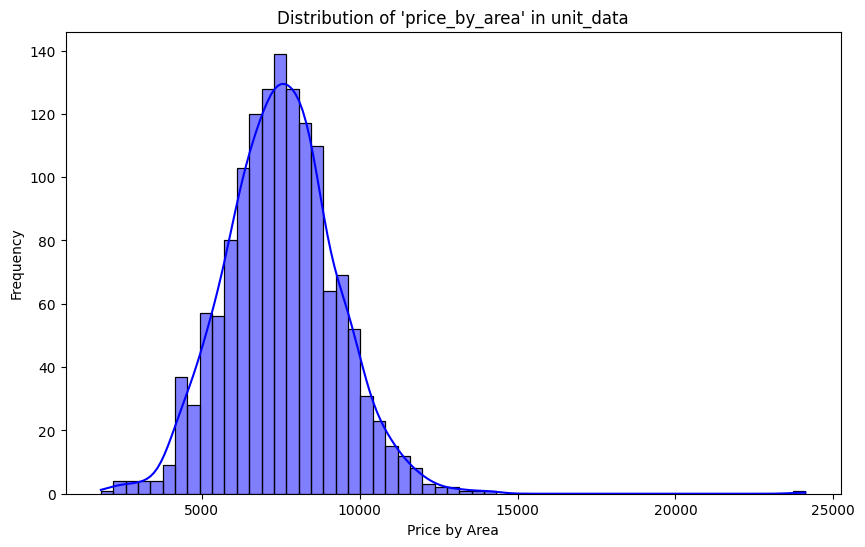

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(unit_data['price_by_area'], kde=True, color='b')
plt.title("Distribution of 'price_by_area' in unit_data")
plt.xlabel("Price by Area")
plt.ylabel("Frequency")
plt.show()

In [35]:
import numpy as np

mean_price_by_area = unit_data['price_by_area'].mean()
std_price_by_area = unit_data['price_by_area'].std()

lower_limit = mean_price_by_area - 3 * std_price_by_area
upper_limit = mean_price_by_area + 3 * std_price_by_area

unit_data = unit_data[(unit_data['price_by_area'] >= lower_limit) & (unit_data['price_by_area'] <= upper_limit)]

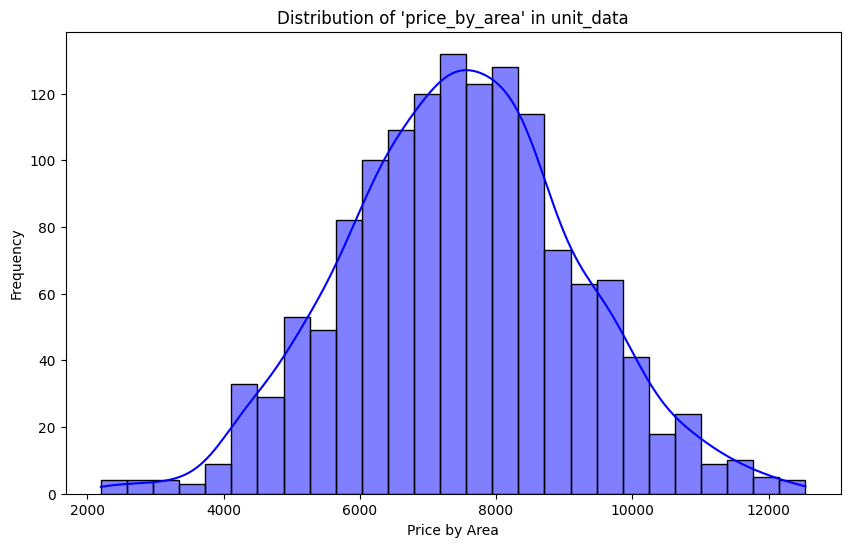

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(unit_data['price_by_area'], kde=True, color='b')
plt.title("Distribution of 'price_by_area' in unit_data")
plt.xlabel("Price by Area")
plt.ylabel("Frequency")
plt.show()

In [37]:
import pandas as pd

# Define price range rules
price_bins = [2000, 4000, 6000, 10000, float('inf')]
price_labels = ['2000-4000', '4000-6000', '6000-10000', 'Above 10000']

# Use the cut function to map "price_by_area" to the interval
unit_data['price_by_area_interval'] = pd.cut(unit_data['price_by_area'], bins=price_bins, labels=price_labels, right=False)

# Convert the result to a category of string type
unit_data['price_by_area_interval'] = unit_data['price_by_area_interval'].astype('category')

In [38]:
# Calculate the frequency of different types in the "price_by_area_interval" column
frequency = unit_data['price_by_area_interval'].value_counts()

#Print frequency results
print(frequency)

6000-10000     1042
4000-6000       243
Above 10000     102
2000-4000        20
Name: price_by_area_interval, dtype: int64


townhouse_data

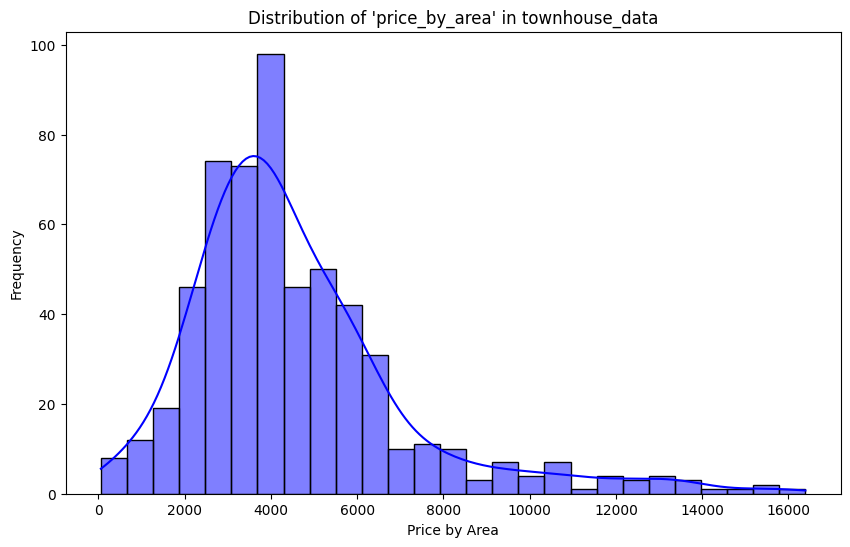

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(townhouse_data['price_by_area'], kde=True, color='b')
plt.title("Distribution of 'price_by_area' in townhouse_data")
plt.xlabel("Price by Area")
plt.ylabel("Frequency")
plt.show()

In [40]:
import numpy as np

mean_price_by_area = townhouse_data['price_by_area'].mean()
std_price_by_area = townhouse_data['price_by_area'].std()

lower_limit = mean_price_by_area - 3 * std_price_by_area
upper_limit = mean_price_by_area + 3 * std_price_by_area

townhouse_data = townhouse_data[(townhouse_data['price_by_area'] >= lower_limit) & (townhouse_data['price_by_area'] <= upper_limit)]

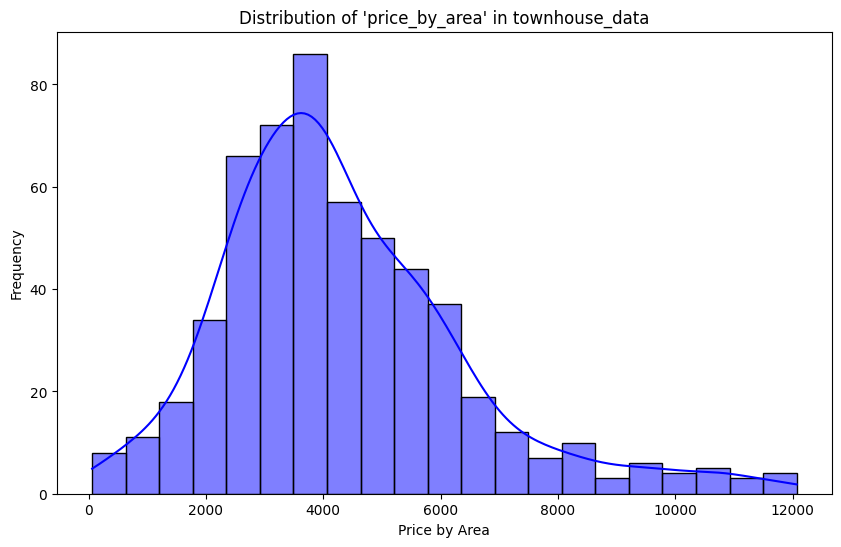

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(townhouse_data['price_by_area'], kde=True, color='b')
plt.title("Distribution of 'price_by_area' in townhouse_data")
plt.xlabel("Price by Area")
plt.ylabel("Frequency")
plt.show()

In [42]:
import pandas as pd

# Define price range rules
price_bins = [0, 2000, 6000, 10000, float('inf')]
price_labels = ['0-2000', '2000-6000', '6000-10000', 'above 10000']

# Use the cut function to map "price_by_area" to the interval
townhouse_data['price_by_area_interval'] = pd.cut(townhouse_data['price_by_area'], bins=price_bins, labels=price_labels, right=False)

In [43]:
# Calculate the frequency of different types in the "price_by_area_interval" column
frequency = townhouse_data['price_by_area_interval'].value_counts()

#Print frequency results
print(frequency)

2000-6000      420
6000-10000      78
0-2000          45
above 10000     13
Name: price_by_area_interval, dtype: int64


drop all price_by_area

In [44]:
# Remove the "price_by_area" column from "house_data"
house_data = house_data.drop(columns=['price_by_area'])

In [45]:
# Remove the "price_by_area" column from "unit_data"
unit_data = unit_data.drop(columns=['price_by_area'])

In [46]:
# Remove the "price_by_area" column from "townhouse_data"
townhouse_data = townhouse_data.drop(columns=['price_by_area'])

In [47]:
house_data.dtypes

ADDRESS              category
ROOMS                   int64
METHOD               category
SELLERG              category
DISTANCE              float64
CAR                     int64
REGIONNAME           category
log_price_by_area     float64
dtype: object

## One-hot encoding

In [48]:
# Perform one-hot encoding on categorical data in "house_data", except "price_by_area_interval"
filtered_house_data = pd.get_dummies(filtered_house_data, columns=[col for col in house_data.columns if house_data[col].dtype.name == 'category' and col != 'log_price_by_area_interval'])

# Perform one-hot encoding on categorical data in "unit_data", except "price_by_area_interval"
unit_data = pd.get_dummies(unit_data, columns=[col for col in unit_data.columns if unit_data[col].dtype.name == 'category' and col != 'price_by_area_interval'])

# Perform one-hot encoding on categorical data in "townhouse_data", except "price_by_area_interval"
townhouse_data = pd.get_dummies(townhouse_data, columns=[col for col in townhouse_data.columns if townhouse_data[col].dtype.name == 'category' and col != 'price_by_area_interval'])

In [49]:
filtered_house_data.dtypes

ROOMS                                       int64
DISTANCE                                  float64
CAR                                         int64
log_price_by_area_interval               category
ADDRESS_Abbotsford Gr                       uint8
                                           ...   
REGIONNAME_Northern Victoria                uint8
REGIONNAME_South-Eastern Metropolitan       uint8
REGIONNAME_Southern Metropolitan            uint8
REGIONNAME_Western Metropolitan             uint8
REGIONNAME_Western Victoria                 uint8
Length: 2659, dtype: object

In [50]:
unit_data.dtypes

ROOMS                                       int64
DISTANCE                                  float64
BATHROOM                                    int64
CAR                                         int64
price_by_area_interval                   category
                                           ...   
REGIONNAME_Eastern Victoria                 uint8
REGIONNAME_Northern Metropolitan            uint8
REGIONNAME_South-Eastern Metropolitan       uint8
REGIONNAME_Southern Metropolitan            uint8
REGIONNAME_Western Metropolitan             uint8
Length: 904, dtype: object

In [51]:
townhouse_data.dtypes

ROOMS                        int64
DISTANCE                   float64
CAR                          int64
price_by_area_interval    category
SUBURB_Aberfeldie            uint8
                            ...   
AREANUM_4                    uint8
AREANUM_5                    uint8
AREANUM_6                    uint8
AREANUM_7                    uint8
AREANUM_8                    uint8
Length: 837, dtype: object

## Models Building

#### house data

random forest models

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = filtered_house_data.drop(columns=['log_price_by_area_interval'])
y = filtered_house_data['log_price_by_area_interval']

params_combinations = [
    {'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    
    {'n_estimators': 200, 'max_depth': 10,'min_samples_split': 2,  'random_state': 42},
    {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42},
    {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42},
    {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42},

    {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 4, 'random_state': 42},

    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 400, 'max_depth': 40, 'min_samples_split': 4, 'random_state': 42},

    {'n_estimators': 500, 'max_depth': 50, 'min_samples_split': 6, 'random_state': 42},
    {'n_estimators': 1000, 'max_depth': 100, 'min_samples_split': 6, 'random_state': 42},
]

models = []
for params in params_combinations:
    model = RandomForestClassifier(**params)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    models.append((model, accuracy))

for i, (model, accuracy) in enumerate(models):
    print(f"Model {i + 1} - Accuracy: {accuracy:.2f}")

Model 1 - Accuracy: 0.60
Model 2 - Accuracy: 0.60
Model 3 - Accuracy: 0.59
Model 4 - Accuracy: 0.59
Model 5 - Accuracy: 0.58
Model 6 - Accuracy: 0.64
Model 7 - Accuracy: 0.67
Model 8 - Accuracy: 0.68
Model 9 - Accuracy: 0.68
Model 10 - Accuracy: 0.64
Model 11 - Accuracy: 0.67
Model 12 - Accuracy: 0.68
Model 13 - Accuracy: 0.68
Model 14 - Accuracy: 0.69


svm models

In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare features and target variables
X = filtered_house_data.drop(columns=['log_price_by_area_interval'])
y = filtered_house_data['log_price_by_area_interval']

# Define different RBF kernel SVM parameter combinations
rbf_svm_param_combinations = [
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale', 'random_state': 42},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale', 'random_state': 42},
    {'C': 0.01, 'kernel': 'rbf', 'gamma': 'scale', 'random_state': 42},
    
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.1, 'random_state': 42},
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42},
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42},
    
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.1, 'random_state': 42},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.001, 'random_state': 42},

    {'C': 10.0, 'kernel': 'rbf', 'gamma': 0.1, 'random_state': 42},
    {'C': 10.0, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42}
]

#Train and evaluate different RBF kernel SVM models
svm_models = []
for params in rbf_svm_param_combinations:
     model = SVC(**params)
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
     model.fit(X_train, y_train)
     y_pred = model.predict(X_test)
     accuracy = accuracy_score(y_test, y_pred)
     svm_models.append((model, accuracy))

#Print the accuracy of the SVM model
for i, (model, accuracy) in enumerate(svm_models):
     print(f"SVM Model {i + 1} - Parameters: {model.get_params()} - Accuracy: {accuracy:.2f}")

SVM Model 1 - Parameters: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False} - Accuracy: 0.66
SVM Model 2 - Parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False} - Accuracy: 0.67
SVM Model 3 - Parameters: {'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False} - Accuracy: 0.63
SVM Model 4 - Parameters: {'C': 0.1,

ANN Models

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Define feature variables (X) and target variables (y)
X = filtered_house_data.drop(columns=['log_price_by_area_interval'])
y = filtered_house_data['log_price_by_area_interval']

# Encode multi-category target variables into integer labels
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y_encoded = y.map(label_mapping)

# Divide the data set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert integer labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Parameter combinations for ANN
param_combinations = [
    {'hidden_layer_1': 64, 'hidden_layer_2': 32, 'hidden_layer_3': 16, 'epochs': 20, 'batch_size': 32},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'hidden_layer_3': 32, 'epochs': 20, 'batch_size': 32},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 10, 'batch_size': 64},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 30, 'batch_size': 16},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 20, 'batch_size': 32, 'optimizer': 'adam', 'learning_rate': 0.001},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 20, 'batch_size': 32, 'optimizer': 'sgd', 'learning_rate': 0.01}
]

# Create a DataFrame to store model results
results_df = pd.DataFrame(columns=['Model Name', 'Parameters', 'Accuracy'])

# Create and train multiple ANN models
for i, params in enumerate(param_combinations):
    model_name = f"ann_model_{i+1}"
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(params['hidden_layer_1'], activation='relu'))
    model.add(layers.Dense(params['hidden_layer_2'], activation='relu'))
    model.add(layers.Dense(len(label_mapping), activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train_one_hot, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2)
    
    y_pred_one_hot = model.predict(X_test)
    y_pred = np.argmax(y_pred_one_hot, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append results to DataFrame
    results_df = results_df.append({
        'Model Name': model_name,
        'Parameters': params,
        'Accuracy': accuracy
    }, ignore_index=True)

# Output results
print(results_df)

Epoch 1/20
81/81 [==============================] - 3s 16ms/step - loss: 1.0239 - accuracy: 0.5428 - val_loss: 0.8953 - val_accuracy: 0.6155
Epoch 2/20
81/81 [==============================] - 1s 10ms/step - loss: 0.7719 - accuracy: 0.6580 - val_loss: 0.7418 - val_accuracy: 0.6450
Epoch 3/20
81/81 [==============================] - 1s 10ms/step - loss: 0.6531 - accuracy: 0.7142 - val_loss: 0.7149 - val_accuracy: 0.6760
Epoch 4/20
81/81 [==============================] - 1s 10ms/step - loss: 0.5710 - accuracy: 0.7654 - val_loss: 0.6989 - val_accuracy: 0.6884
Epoch 5/20
81/81 [==============================] - 1s 10ms/step - loss: 0.5089 - accuracy: 0.8042 - val_loss: 0.6993 - val_accuracy: 0.7008
Epoch 6/20
81/81 [==============================] - 1s 9ms/step - loss: 0.4346 - accuracy: 0.8410 - val_loss: 0.7068 - val_accuracy: 0.6977
Epoch 7/20
81/81 [==============================] - 1s 10ms/step - loss: 0.3608 - accuracy: 0.8771 - val_loss: 0.7518 - val_accuracy: 0.6806
Epoch 8/20
81/

Naive Bayesracy: {accuracy:.2f}")


In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Define feature variables (X) and target variables (y)
X = filtered_house_data.drop(columns=['log_price_by_area_interval'])
y = filtered_house_data['log_price_by_area_interval']

# Divide the data set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Multinomial Naive Bayes classifier
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

# Predict on the test set
y_pred = naive_bayes_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Output accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Define feature variables (X) and target variables (y)
X = filtered_house_data.drop(columns=['log_price_by_area_interval'])
y = filtered_house_data['log_price_by_area_interval']

# Divide the data set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Gaussian Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

# Predict on the test set
y_pred = naive_bayes_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Output accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.33


### unit data

random forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = unit_data.drop(columns=['price_by_area_interval'])
y = unit_data['price_by_area_interval']

params_combinations = [
    {'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    
    {'n_estimators': 200, 'max_depth': 10,'min_samples_split': 2,  'random_state': 42},
    {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42},
    {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42},
    {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42},

    {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 4, 'random_state': 42},

    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 400, 'max_depth': 40, 'min_samples_split': 4, 'random_state': 42},

    {'n_estimators': 500, 'max_depth': 50, 'min_samples_split': 6, 'random_state': 42},
    {'n_estimators': 1000, 'max_depth': 100, 'min_samples_split': 6, 'random_state': 42},
]

models = []
for params in params_combinations:
    model = RandomForestClassifier(**params)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    models.append((model, accuracy))

for i, (model, accuracy) in enumerate(models):
    print(f"Model {i + 1} - Accuracy: {accuracy:.2f}")

Model 1 - Accuracy: 0.73
Model 2 - Accuracy: 0.73
Model 3 - Accuracy: 0.73
Model 4 - Accuracy: 0.73
Model 5 - Accuracy: 0.73
Model 6 - Accuracy: 0.74
Model 7 - Accuracy: 0.78
Model 8 - Accuracy: 0.79
Model 9 - Accuracy: 0.79
Model 10 - Accuracy: 0.74
Model 11 - Accuracy: 0.77
Model 12 - Accuracy: 0.79
Model 13 - Accuracy: 0.79
Model 14 - Accuracy: 0.80


SVM

In [58]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare features and target variables
X = unit_data.drop(columns=['price_by_area_interval'])
y = unit_data['price_by_area_interval']

# Define different RBF kernel SVM parameter combinations
rbf_svm_param_combinations = [
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale', 'random_state': 42},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale', 'random_state': 42},
    {'C': 0.01, 'kernel': 'rbf', 'gamma': 'scale', 'random_state': 42},
    
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.1, 'random_state': 42},
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42},
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42},
    
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.1, 'random_state': 42},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.001, 'random_state': 42},

    {'C': 10.0, 'kernel': 'rbf', 'gamma': 0.1, 'random_state': 42},
    {'C': 10.0, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42}
]

# Train and evaluate different RBF kernel SVM models
svm_models = []
for params in rbf_svm_param_combinations:
    model = SVC(**params)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svm_models.append((model, accuracy))

# Print the accuracy of the SVM models
for i, (model, accuracy) in enumerate(svm_models):
    print(f"SVM Model {i + 1} - Parameters: {model.get_params()} - Accuracy: {accuracy:.2f}")

SVM Model 1 - Parameters: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False} - Accuracy: 0.73
SVM Model 2 - Parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False} - Accuracy: 0.73
SVM Model 3 - Parameters: {'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False} - Accuracy: 0.73
SVM Model 4 - Parameters: {'C': 0.1,

ANN

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Define feature variables (X) and target variables (y)
X = unit_data.drop(columns=['price_by_area_interval'])
y = unit_data['price_by_area_interval']

# Encode multi-category target variables into integer labels
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y_encoded = y.map(label_mapping)

# Divide the data set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert integer labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Parameter combinations for ANN
param_combinations = [
    {'hidden_layer_1': 64, 'hidden_layer_2': 32, 'hidden_layer_3': 16, 'epochs': 20, 'batch_size': 32},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'hidden_layer_3': 32, 'epochs': 20, 'batch_size': 32},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 10, 'batch_size': 64},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 30, 'batch_size': 16},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 20, 'batch_size': 32, 'optimizer': 'adam', 'learning_rate': 0.001},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 20, 'batch_size': 32, 'optimizer': 'sgd', 'learning_rate': 0.01}
]

# Create a DataFrame to store model results
results_df = pd.DataFrame(columns=['Model Name', 'Parameters', 'Accuracy'])

# Create and train multiple ANN models
for i, params in enumerate(param_combinations):
    model_name = f"ann_model_{i+1}"
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(params['hidden_layer_1'], activation='relu'))
    model.add(layers.Dense(params['hidden_layer_2'], activation='relu'))
    model.add(layers.Dense(len(label_mapping), activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train_one_hot, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2)
    
    y_pred_one_hot = model.predict(X_test)
    y_pred = np.argmax(y_pred_one_hot, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append results to DataFrame
    results_df = results_df.append({
        'Model Name': model_name,
        'Parameters': params,
        'Accuracy': accuracy
    }, ignore_index=True)

# Output results
print(results_df)

Epoch 1/20
29/29 [==============================] - 2s 25ms/step - loss: 1.1611 - accuracy: 0.6567 - val_loss: 0.9102 - val_accuracy: 0.7600
Epoch 2/20
29/29 [==============================] - 0s 14ms/step - loss: 0.8282 - accuracy: 0.7378 - val_loss: 0.7221 - val_accuracy: 0.7600
Epoch 3/20
29/29 [==============================] - 0s 15ms/step - loss: 0.7189 - accuracy: 0.7378 - val_loss: 0.6811 - val_accuracy: 0.7600
Epoch 4/20
29/29 [==============================] - 0s 12ms/step - loss: 0.6665 - accuracy: 0.7478 - val_loss: 0.6584 - val_accuracy: 0.7467
Epoch 5/20
29/29 [==============================] - 0s 12ms/step - loss: 0.6207 - accuracy: 0.7844 - val_loss: 0.6554 - val_accuracy: 0.7422
Epoch 6/20
29/29 [==============================] - 0s 13ms/step - loss: 0.5853 - accuracy: 0.7944 - val_loss: 0.6360 - val_accuracy: 0.7467
Epoch 7/20
29/29 [==============================] - 0s 12ms/step - loss: 0.5494 - accuracy: 0.8078 - val_loss: 0.6390 - val_accuracy: 0.7644
Epoch 8/20
29

Bayes

In [60]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare features and target variables
X = unit_data.drop(columns=['price_by_area_interval'])
y = unit_data['price_by_area_interval']

# Define different Naive Bayes parameter combinations
nb_param_combinations = [
    {'alpha': 1.0},
    {'alpha': 0.1},
    {'alpha': 0.01},
    {'alpha': 0.001},
    {'alpha': 0.0001}
]

# Train and evaluate different Naive Bayes models
nb_models = []
for params in nb_param_combinations:
    model = MultinomialNB(**params)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    nb_models.append((model, accuracy))

# Print the accuracy of the Naive Bayes models
for i, (model, accuracy) in enumerate(nb_models):
    print(f"Naive Bayes Model {i + 1} - Parameters: {model.get_params()} - Accuracy: {accuracy:.2f}")

Naive Bayes Model 1 - Parameters: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True} - Accuracy: 0.72
Naive Bayes Model 2 - Parameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': True} - Accuracy: 0.69
Naive Bayes Model 3 - Parameters: {'alpha': 0.01, 'class_prior': None, 'fit_prior': True} - Accuracy: 0.59
Naive Bayes Model 4 - Parameters: {'alpha': 0.001, 'class_prior': None, 'fit_prior': True} - Accuracy: 0.58
Naive Bayes Model 5 - Parameters: {'alpha': 0.0001, 'class_prior': None, 'fit_prior': True} - Accuracy: 0.58


### townhouse data

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = townhouse_data.drop(columns=['price_by_area_interval'])
y = townhouse_data['price_by_area_interval']

params_combinations = [
    {'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    
    {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42},
    {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42},
    {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42},
    {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42},

    {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 4, 'random_state': 42},

    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 4, 'random_state': 42},
    {'n_estimators': 400, 'max_depth': 40, 'min_samples_split': 4, 'random_state': 42},

    {'n_estimators': 500, 'max_depth': 50, 'min_samples_split': 6, 'random_state': 42},
    {'n_estimators': 1000, 'max_depth': 100, 'min_samples_split': 6, 'random_state': 42},
]

models = []
for params in params_combinations:
    model = RandomForestClassifier(**params)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    models.append((model, accuracy))

for i, (model, accuracy) in enumerate(models):
    print(f"Model {i + 1} - Accuracy: {accuracy:.2f}")

Model 1 - Accuracy: 0.79
Model 2 - Accuracy: 0.78
Model 3 - Accuracy: 0.78
Model 4 - Accuracy: 0.78
Model 5 - Accuracy: 0.78
Model 6 - Accuracy: 0.74
Model 7 - Accuracy: 0.73
Model 8 - Accuracy: 0.73
Model 9 - Accuracy: 0.72
Model 10 - Accuracy: 0.74
Model 11 - Accuracy: 0.73
Model 12 - Accuracy: 0.73
Model 13 - Accuracy: 0.73
Model 14 - Accuracy: 0.73


**SVM**

In [62]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare features and target variables
X = townhouse_data.drop(columns=['price_by_area_interval'])
y = townhouse_data['price_by_area_interval']

# Define different RBF kernel SVM parameter combinations
rbf_svm_param_combinations = [
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale', 'random_state': 42},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale', 'random_state': 42},
    {'C': 0.01, 'kernel': 'rbf', 'gamma': 'scale', 'random_state': 42},
    
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.1, 'random_state': 42},
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42},
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42},
    
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.1, 'random_state': 42},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.001, 'random_state': 42},

    {'C': 10.0, 'kernel': 'rbf', 'gamma': 0.1, 'random_state': 42},
    {'C': 10.0, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42}
]

# Train and evaluate different RBF kernel SVM models
svm_models = []
for params in rbf_svm_param_combinations:
    model = SVC(**params)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svm_models.append((model, accuracy))

# Print the accuracy of the SVM models
for i, (model, accuracy) in enumerate(svm_models):
    print(f"SVM Model {i + 1} - Parameters: {model.get_params()} - Accuracy: {accuracy:.2f}")

SVM Model 1 - Parameters: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False} - Accuracy: 0.79
SVM Model 2 - Parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False} - Accuracy: 0.79
SVM Model 3 - Parameters: {'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False} - Accuracy: 0.79
SVM Model 4 - Parameters: {'C': 0.1,

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Prepare features and target variables
X = townhouse_data.drop(columns=['price_by_area_interval'])
y = townhouse_data['price_by_area_interval']

# Encode multi-category target variables into integer labels
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y_encoded = y.map(label_mapping)

# Divide the data set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert integer labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Parameter combinations for ANN
param_combinations = [
    {'hidden_layer_1': 64, 'hidden_layer_2': 32, 'hidden_layer_3': 16, 'epochs': 20, 'batch_size': 32},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'hidden_layer_3': 32, 'epochs': 20, 'batch_size': 32},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 10, 'batch_size': 64},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 30, 'batch_size': 16},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 20, 'batch_size': 32, 'optimizer': 'adam', 'learning_rate': 0.001},
    {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'epochs': 20, 'batch_size': 32, 'optimizer': 'sgd', 'learning_rate': 0.01}
]

# Create a DataFrame to store model results
results_df = pd.DataFrame(columns=['Model Name', 'Parameters', 'Accuracy'])

# Create and train multiple ANN models
for i, params in enumerate(param_combinations):
    model_name = f"ann_model_{i+1}"
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(params['hidden_layer_1'], activation='relu'))
    model.add(layers.Dense(params['hidden_layer_2'], activation='relu'))
    model.add(layers.Dense(len(label_mapping), activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train_one_hot, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2)
    
    y_pred_one_hot = model.predict(X_test)
    y_pred = np.argmax(y_pred_one_hot, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append results to DataFrame
    results_df = results_df.append({
        'Model Name': model_name,
        'Parameters': params,
        'Accuracy': accuracy
    }, ignore_index=True)

# Output results
print(results_df)

Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 0.9407 - accuracy: 0.7324 - val_loss: 0.7400 - val_accuracy: 0.7640
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 0.7724 - accuracy: 0.7408 - val_loss: 0.6927 - val_accuracy: 0.7640
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 0.7282 - accuracy: 0.7408 - val_loss: 0.6837 - val_accuracy: 0.7640
Epoch 4/20
12/12 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.7521 - val_loss: 0.6832 - val_accuracy: 0.7753
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6579 - accuracy: 0.7577 - val_loss: 0.6741 - val_accuracy: 0.7753
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 0.6283 - accuracy: 0.7577 - val_loss: 0.6689 - val_accuracy: 0.7865
Epoch 7/20
12/12 [==============================] - 0s 13ms/step - loss: 0.5876 - accuracy: 0.7746 - val_loss: 0.6699 - val_accuracy: 0.7865
Epoch 8/20
12/12

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare features and target variables
X = townhouse_data.drop(columns=['price_by_area_interval'])
y = townhouse_data['price_by_area_interval']

# Define different Multinomial Naive Bayes parameter combinations
nb_param_combinations = [
    {'alpha': 1.0},
    {'alpha': 0.1},
    {'alpha': 0.01},
    {'alpha': 0.001},
]

# Train and evaluate different Multinomial Naive Bayes models
nb_models = []
for params in nb_param_combinations:
    model = MultinomialNB(**params)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    nb_models.append((model, accuracy))

# Print the accuracy of the Multinomial Naive Bayes models
for i, (model, accuracy) in enumerate(nb_models):
    print(f"Multinomial Naive Bayes Model {i + 1} - Parameters: {model.get_params()} - Accuracy: {accuracy:.2f}")

Multinomial Naive Bayes Model 1 - Parameters: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True} - Accuracy: 0.74
Multinomial Naive Bayes Model 2 - Parameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': True} - Accuracy: 0.54
Multinomial Naive Bayes Model 3 - Parameters: {'alpha': 0.01, 'class_prior': None, 'fit_prior': True} - Accuracy: 0.54
Multinomial Naive Bayes Model 4 - Parameters: {'alpha': 0.001, 'class_prior': None, 'fit_prior': True} - Accuracy: 0.55
